# DEDDIAG
This Jupyter Notebook presents the DEDDIAG dataset, a rich source of data on household electricity demand in Germany. Our analysis specifically focuses on the data from house 05, offering insights into the electricity usage patterns of various household appliances.  
This notebook is designed to be adaptable for analyzing data from other houses in the dataset as well.

The dataset is organized as follows
* House Directories: Each house in the dataset has a dedicated directory.  
* Demographic Data: Found in house.tsv, providing information about the residents.  
* Appliance Metadata: Stored in items.tsv, categorizing appliances like Refrigerators, Washing Machines, etc.  
* Detailed Appliance Data: Each appliance's data is split across three files
     * item_XXXX_data.tsv.gz: Contains raw power readings. A measurement record is stored as < item_id > < time > < value > where < item_id > corresponds to an ID in items.tsv. <time> is a UTC datetime string using the YYYY-MM-DD HH:MI:SS.US format, measurements are stored as float values.
     * item_XXXX_annotations.tsv: Includes annotations for the data provided as < id > < item_id > < label_id > < start_date > < stop_date > where start, stop, are UTC datetime strings using the YYYY-MM-DD HH:MI:SS format.
     * item_XXXX_annotation_labels.tsv: Provides labels for the annotations

## Content Overview
1) [Available Appliances](#available_appliances)
2) [Loading and Storing the Data](#Loading_the_data)
3) [Missing Values and Duplicates](#missing_values_and_duplicates)
4) [Summary Statistics](#summary_statistics)
    * [Boxplot](#boxplot)
5) [Measurement Gaps Occurrence](#measurement-gaps)
    * [Gaps Heatmap](#heatmap_gaps)
6) [Total Energy Consumption per Appliance](#total_consumption_per_app_plot)
7) [Resampling and Alligning the Data](#resample_allign_plot)
    * [Histogram](#resampled_D_histograms)
    * [Line Plot of Data Over Time](#resample_line_plot)
    * [Stacked Bar Plot](#resample_stackedbar_plot)
8) [Plotting Appliance Power Measurements with Start/Stop Annotations](#annotations_plot)
9) [Peak Hours Analysis](#cpeak_hour)
    * [Coffee Machine Peak hour, an example](#cpeak_hour)
    * [Peak Hours Heatmap for All Appliances](#peak_hour_heatmap)

## Note on Data Exclusion:
For this analysis, the appliance 'Office desk' (item_id 8) has been omitted due to its extensive data size (over 60 million rows), which poses challenges for efficient data processing in this context.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

<a id="available_appliances"></a>
## Available Appliances

In [2]:
appliances_df = pd.read_csv('../files/DEDDIAG/items.tsv', sep='\t')
appliances_df

item_id                   label         category  house
0        5        Bosch SMS69N48EU      Dish Washer      5
1        8             Office Desk      Office Desk      5
2       30            Bezzera BZ09   Coffee Machine      5
3        9               Bauknecht     Refrigerator      5
4        6  Miele SOFTTRONIC W2241  Washing Machine      5

<a id="Loading_the_data"></a>
## Loading the Data

In [3]:
#Loading data for the Dish Washer
df_0005= pd.read_csv('../files/DEDDIAG/item_0005_data.tsv', sep='\t', index_col='time')
df_0005.sort_index(inplace= True) 
annotations_0005 = pd.read_csv('../files/DEDDIAG/item_0005_annotations.tsv', sep='\t')
annotations_0005=annotations_0005.sort_values(by='start_date')

In [4]:
#Loading data for the Washing Machine
df_0006 = pd.read_csv('../files/DEDDIAG/item_0006_data.tsv', sep='\t', index_col='time')
df_0006.sort_index(inplace= True) 
annotations_0006 = pd.read_csv('../files/DEDDIAG/item_0006_annotations.tsv', sep='\t')
annotations_0006=annotations_0006.sort_values(by='start_date')

In [5]:
#Loading data for the Refregirator
df_0009 = pd.read_csv('../files/DEDDIAG/item_0009_data.tsv', sep='\t', index_col='time')
df_0009.sort_index(inplace= True) 
annotations_0009 = pd.read_csv('../files/DEDDIAG/item_0009_annotations.tsv', sep='\t')
annotations_0009=annotations_0009.sort_values(by='start_date')

In [6]:
#Loading data for the Coffee Machine. No annotations available
df_0030 = pd.read_csv('../files/DEDDIAG/item_0030_data.tsv', sep='\t', index_col='time')
df_0030.sort_index(inplace= True) 

In [7]:
#storing the dataframes and item id in dictionaries
dataframes_dict = {
    5: df_0005,
    6: df_0006,
    9: df_0009,
    30: df_0030}

annotations_dict = {
    5: annotations_0005,
    6: annotations_0006,
    9: annotations_0009}

In [10]:
# Getting the appliance name from the item_id (for plots legends and annotations)
def map_item_id_to_name(appliances_df, item_ids):

    item_to_category = dict(zip(appliances_df['item_id'], appliances_df['category']))
    return [item_to_category.get(item_id) for item_id in item_ids]

<a id="missing_values_and_duplicates"></a>
## Missing Values and Duplicates

In [55]:
def calculate_missing_and_duplicates(dataframes_dict):
    missing_values_counts = {}
    duplicates_counts = {}

    for df_name, df in dataframes_dict.items():
        # Calculate total missing values
        missing_values = df.isnull().sum().sum()
        missing_values_counts[df_name] = missing_values

        # Calculate total duplicates
        duplicates = df[df.index.duplicated()].shape[0]
        duplicates_counts[df_name] = duplicates

    return missing_values_counts, duplicates_counts

In [56]:
def plot_missing_and_duplicates(missing_values_counts, duplicates_counts, appliances):
    appliance_names = [map_item_id_to_name(appliances_df, [item_id])[0] for item_id in missing_values_counts.keys()]
    missing_values = list(missing_values_counts.values())
    duplicates = list(duplicates_counts.values())

    bar_width = 0.35
    index = np.arange(len(missing_values_counts))

    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(index, missing_values, bar_width, color='cornflowerblue', alpha=0.7, label='Missing Values')
    bars2 = plt.bar(index + bar_width, duplicates, bar_width, color='mediumorchid',alpha=0.7 ,label='Duplicates')

    # Adding the counts above the bars
    for bar in bars1:
        height = bar.get_height()
        plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                     textcoords="offset points", ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                     textcoords="offset points", ha='center', va='bottom')

    plt.xlabel('Appliance')
    plt.ylabel('Counts')
    plt.title('Missing Values and Duplicates per Appliance')
    plt.xticks(index + bar_width / 2, appliance_names)
    plt.legend()

    plt.tight_layout()
    plt.show()


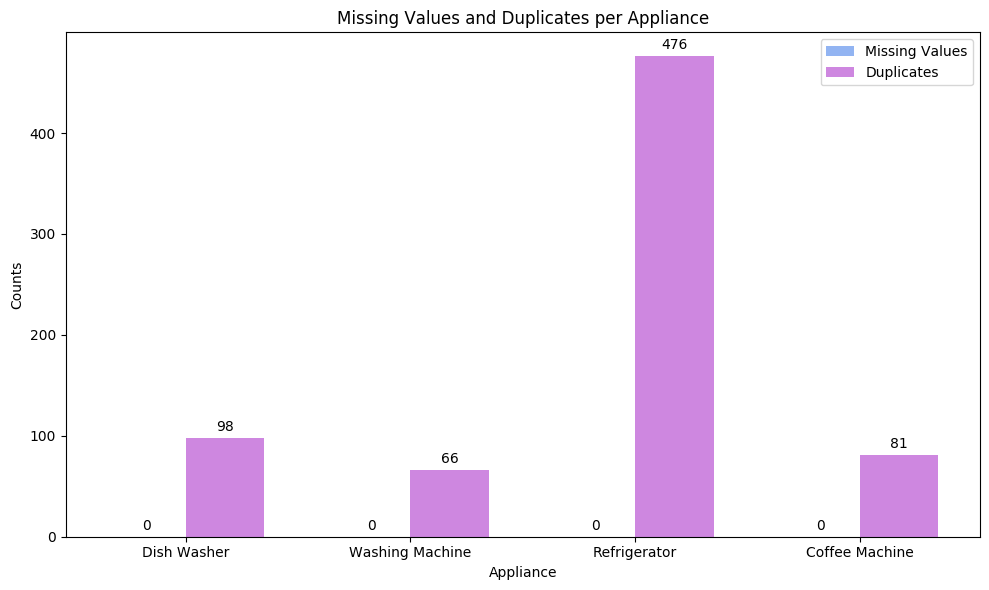

In [57]:
missing_values_counts, duplicates_counts = calculate_missing_and_duplicates(dataframes_dict)
plot_missing_and_duplicates(missing_values_counts, duplicates_counts, appliances_df)

## Removing the duplicates

In [58]:
for item_id, df in dataframes_dict.items():
    # Convert index to datetime 
    df.index = pd.to_datetime(df.index)
    # Group by index and take the mean, then update the DataFrame in the dictionary
    dataframes_dict[item_id] = df.groupby(df.index).mean()

<a id="summary_statistics"></a>
## Summary Statistics

In [13]:
def stats(appliances_df, dataframes_dict):
    stats_dfs = []
    for item_id in appliances_df['item_id']:
        if item_id in dataframes_dict:
            if 'value' in dataframes_dict[item_id].columns:
                # Get descriptive statistics for the 'value' column
                stats = dataframes_dict[item_id]['value'].describe()
                # Convert to DataFrame
                stats_df = stats.to_frame().transpose()
                # Add an 'item_id' column
                stats_df['item_id'] = item_id
                stats_dfs.append(stats_df)
            else:
                print(f"'value' column not found in DataFrame for item_id {item_id}.")
        else:
            print(f"DataFrame for item_id {item_id} not found.")
    # Concatenate the description DataFrames
    return pd.concat(stats_dfs, ignore_index=True)

stats_df = stats(appliances_df, dataframes_dict)

DataFrame for item_id 8 not found.


In [14]:
stats_df.set_index('item_id', inplace=True)
stats_df=stats_df.T
stats_df

item_id            5             30            9             6 
count    3.239943e+06  1.985211e+06  1.527027e+07  2.105901e+06
mean     3.104001e+02  2.764578e+02  5.349922e+01  2.027707e+02
std      7.333432e+02  4.699531e+02  3.532025e+01  5.412152e+02
min      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%      2.490096e+00  9.582407e+01  4.990659e+01  1.666505e+00
50%      2.218092e+01  9.674816e+01  5.212855e+01  2.373109e+00
75%      4.697334e+01  9.779689e+01  5.421911e+01  8.362444e+01
max      9.063741e+03  9.269169e+03  9.066496e+03  2.177914e+03

## Boxplots

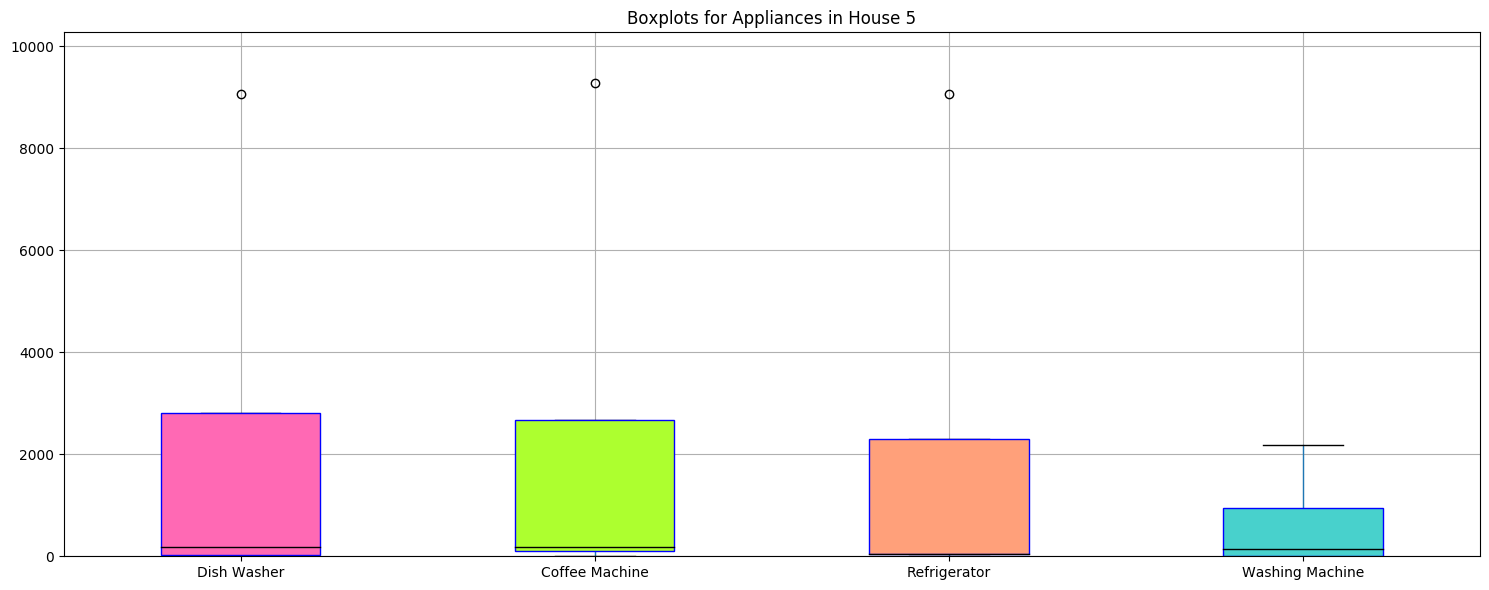

In [15]:
appliance_names = map_item_id_to_name(appliances_df, stats_df.columns)
max_y = stats_df.iloc[7].max() + 1000  
colors = ['hotpink','greenyellow', 'lightsalmon', 'mediumturquoise', 'mediumvioletred', 'yellowgreen', 'deepskyblue']
plt.figure(figsize=(15, 6))
stats_df.boxplot(patch_artist=True, boxprops=dict(facecolor='b', color='b'), medianprops=dict(color='black'))
for patch, color in zip(plt.gca().artists, colors):
    patch.set_facecolor(color)
plt.title('Boxplots for Appliances in House 5')
plt.ylim(0, max_y)
plt.xticks(range(1, len(appliance_names) + 1), appliance_names)
plt.tight_layout()
plt.show()

<a id="measurement_gaps"></a>
## Measurement Gaps Occurrences

In [ ]:
def count_gaps(dataframes_dict, thresholds):
    gap_counts = {threshold: [] for threshold in thresholds}
    thresholds.sort(reverse=True)  # Ensure thresholds are in descending order

    for df_name, df in dataframes_dict.items():
        df.index = pd.to_datetime(df.index)
        # Calculate time differences between consecutive measurements
        time_diffs = df.index.to_series().diff().dt.total_seconds().fillna(0)
        for i, threshold in enumerate(thresholds):
            # Set upper limit for the current threshold
            upper_limit = np.inf if i == 0 else thresholds[i - 1]
            # Count gaps that are greater than the current threshold but less than the upper limit
            gap_count = ((time_diffs > threshold) & (time_diffs < upper_limit)).sum()
            gap_counts[threshold].append(gap_count)
   
    return gap_counts

In [26]:
def plot_gap_occurrences(gap_counts, appliance_names):
    heatmap_data = pd.DataFrame(gap_counts, index=appliance_names)
    heatmap_data = heatmap_data.T 
    epsilon = 1e-9
    heatmap_data += epsilon
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="magma", norm=LogNorm())
    plt.title('Gap Occurrences by Appliance and Threshold')
    plt.ylabel('Threshold')
    plt.xlabel('Appliance Name')
    plt.xticks(rotation=45)
    plt.yticks(ticks=np.arange(len(heatmap_data.index)), labels=[format_threshold(th) for th in heatmap_data.index], rotation=0)
    plt.show()

<a id="heatmap_gaps"></a>
## Gaps Heatmap

In [ ]:
# formatting the threshholds for prettier y axis ticks
def format_threshold(seconds):
    if seconds >= 3600:
        return f"{seconds // 3600}h"
    elif seconds >= 60:
        return f"{seconds // 60}m"
    else:
        return f"{seconds}s"

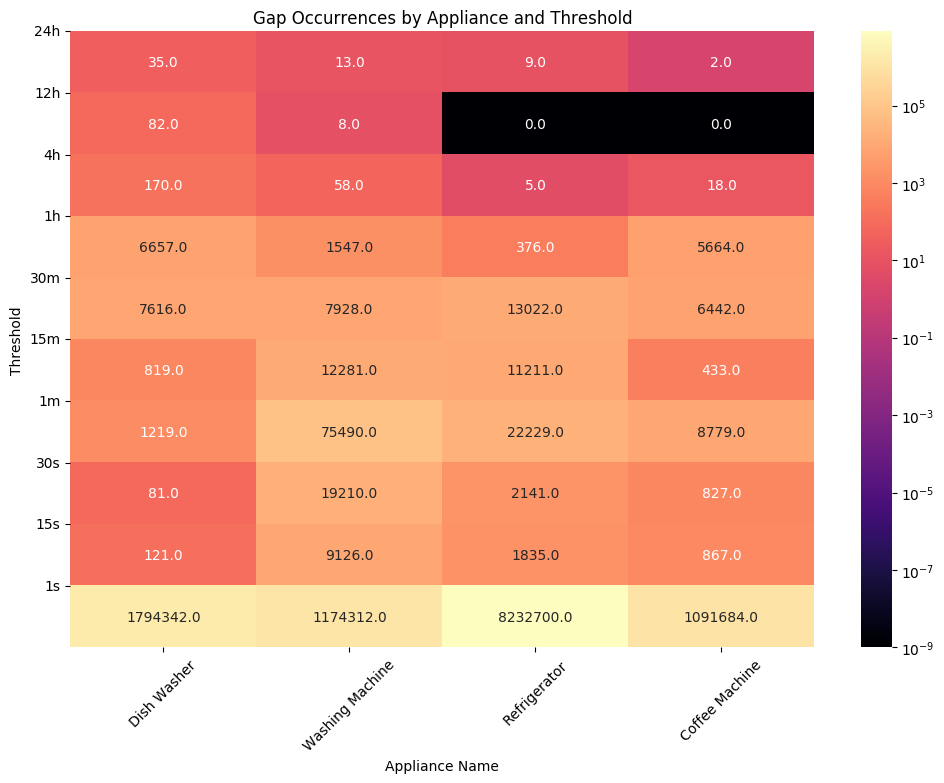

In [27]:
thresholds = [86400, 43200, 14400, 3600, 1800, 900, 60, 30, 15, 1] 
appliance_names = [map_item_id_to_name(appliances_df, [item_id])[0] for item_id in dataframes_dict.keys()]
gap_counts = count_gaps(dataframes_dict, thresholds)
plot_gap_occurrences(gap_counts, appliance_names)

<a id="total_consumption_per_app_plot"></a>
## Total Energy Consumption per Appliance

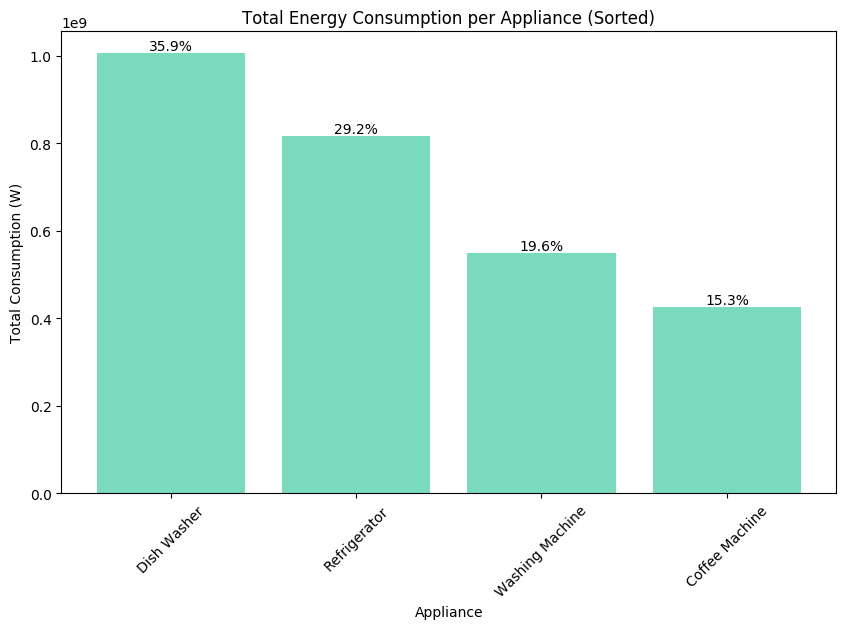

In [16]:
# Calculate the total consumption for each appliance
total_consumption = {}
total_consumption_all = 0  # Initialize total consumption across all appliances

for appliance_name, df in zip(appliance_names, dataframes_dict.values()):
    appliance_total = df['value'].sum()
    total_consumption[appliance_name] = appliance_total
    total_consumption_all += appliance_total

# Convert the totals to a DataFrame for easy plotting
total_consumption_df = pd.DataFrame(list(total_consumption.items()), columns=['Appliance', 'Total Consumption'])

# Sort the DataFrame by 'Total Consumption' in descending order
sorted_total_consumption_df = total_consumption_df.sort_values(by='Total Consumption', ascending=False)

# Plotting the sorted bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_total_consumption_df['Appliance'], sorted_total_consumption_df['Total Consumption'], color='#58d1ad', alpha=0.8)

# Annotate each bar with the percentage of the total consumption
for bar in bars:
    yval = bar.get_height()
    pct = (yval / total_consumption_all) * 100  # Calculate percentage
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{pct:.1f}%', ha='center', va='bottom')

plt.title('Total Energy Consumption per Appliance (Sorted)')
plt.xlabel('Appliance')
plt.ylabel('Total Consumption (W)')
plt.xticks(rotation=45)
plt.show()


<a id="resample_allign_plot"></a>
## Resampling and Alligning the Data

In [17]:
# Define the resampling frequency
resample_freq = 'D'  # 'D' for daily

# New dictionary to store the resampled data
resampled_dataframes_dict = {}

# Resample each DataFrame and store in the new dictionary
for df_name, df in dataframes_dict.items():
    df.index = pd.to_datetime(df.index)
    # Resample the DataFrame
    df_resampled = df.resample(resample_freq).mean()

    # Store the resampled DataFrame in the new dictionary
    resampled_dataframes_dict[df_name] = df_resampled

In [18]:
# Data frames timestamps allignment 
earliest_start = pd.Timestamp.max
latest_end = pd.Timestamp.min

for df in resampled_dataframes_dict.values():
    df_earliest = df.index.min()
    df_latest = df.index.max()

    if df_earliest < earliest_start:
        earliest_start = df_earliest

    if df_latest > latest_end:
        latest_end = df_latest

# Align all dataframes to the date range
aligned_dataframes_dict = {}
for df_name, df in resampled_dataframes_dict.items():
    all_dates = pd.date_range(start=earliest_start, end=latest_end, freq='D')
    aligned_dataframes_dict[df_name] = df.reindex(all_dates)


<a id="resampled_D_histograms"></a>
## Histograms of Data Resampled to One day

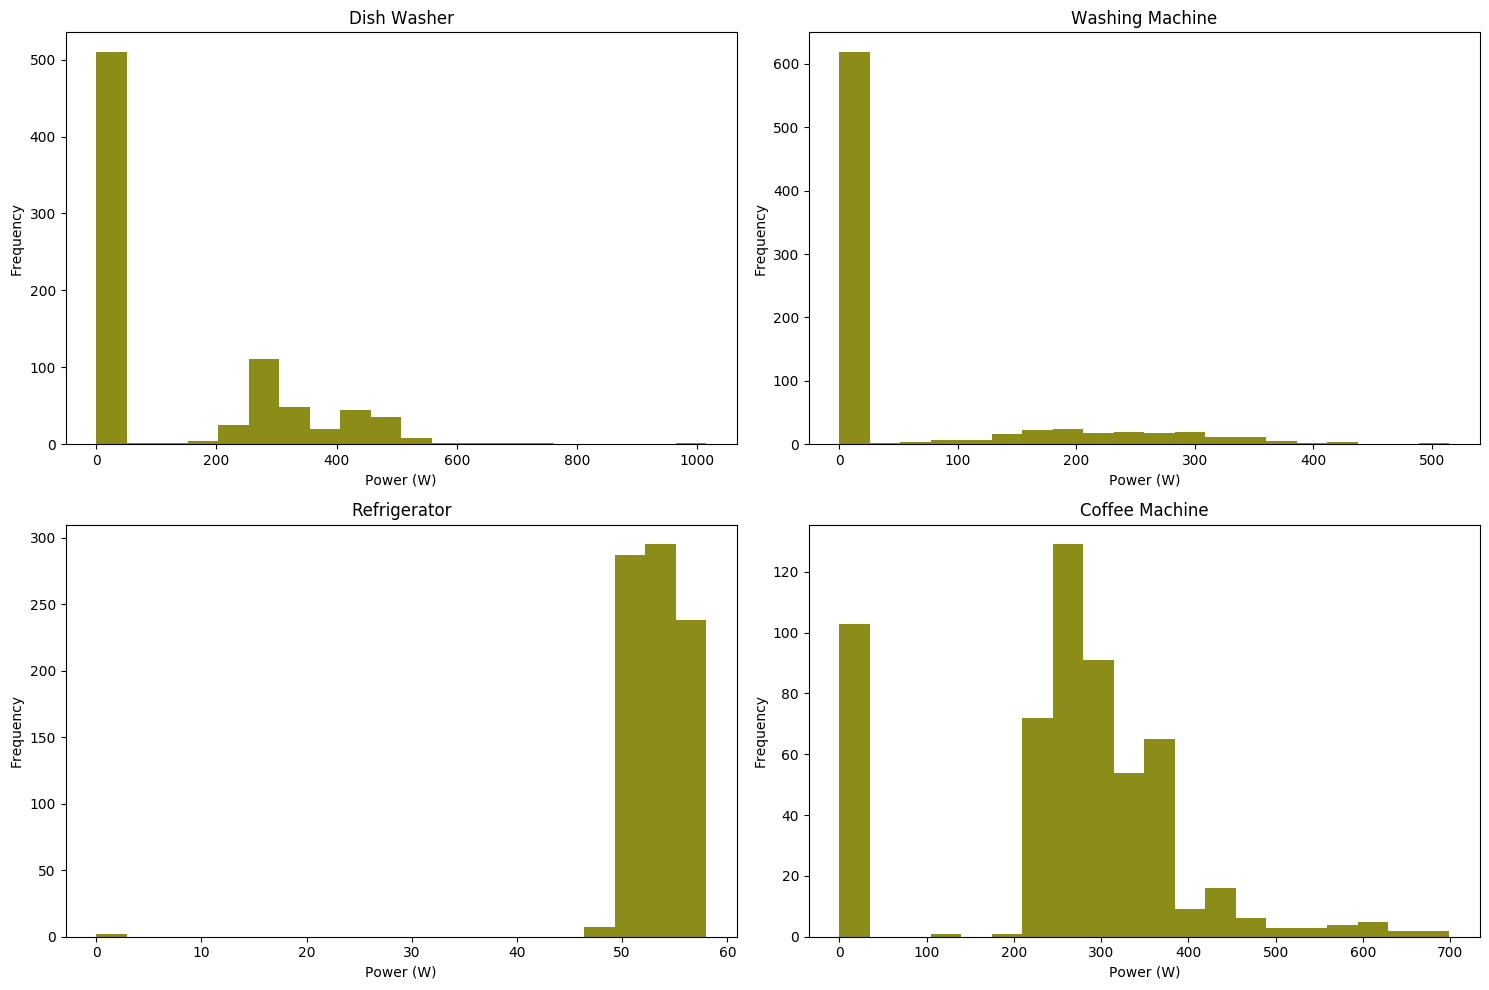

In [19]:
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

for i, (item_id, df) in enumerate(resampled_dataframes_dict.items(), start=1):
    appliance_name = map_item_id_to_name(appliances_df, [item_id])[0]  # Get appliance name
    plt.subplot(2, 2, i) 
    plt.hist(df['value'], bins=20, color='olive', alpha=0.9)
    plt.title(appliance_name) 
    plt.xlabel('Power (W)') 
    plt.ylabel('Frequency')  

plt.tight_layout()
plt.show()



<a id="resample_line_plot"></a>
## Line Plot of Data Over Time

In [20]:
num_dfs = len(aligned_dataframes_dict)
colors = cm.rainbow(np.linspace(0, 1, num_dfs))  # Generates a spectrum of colors

plt.figure(figsize=(15, 6))
appliance_names = [map_item_id_to_name(appliances_df, [item_id])[0] for item_id in dataframes_dict.keys()]

for (df_name, df), appliance_name, color in zip(aligned_dataframes_dict.items(), appliance_names, colors):
    plt.plot(df.index.to_numpy(), df['value'].to_numpy(), label=appliance_name, color=color) 

# Formatting the x-axis to show a tick every 100 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.title('Resampled and Aligned Data Over Time for All Appliances')
plt.xlabel('Date')
plt.ylabel('Power (W)')  
plt.legend()
plt.grid(True)
plt.show()


<a id="resample_stackedbar_plot"></a>
## Stacked Barplot

In [21]:
# Combine all dataframes into a single dataframe for plotting
combined_df = pd.DataFrame(index=aligned_dataframes_dict[list(aligned_dataframes_dict.keys())[0]].index)
for appliance_name, df in zip(appliance_names, aligned_dataframes_dict.values()):
    combined_df[appliance_name] = df['value']  

# Convert index to date (YYYY-MM-DD) format for plotting
combined_df.index = combined_df.index.date

# Plotting the stacked bar chart
plt.figure(figsize=(15, 6))
combined_df.plot(kind='bar', stacked=True, ax=plt.gca())

# Formatting the x-axis to show a tick every 100 days
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.xticks(rotation=45)

plt.title('Stacked Bar Plot of Resampled Data for All Appliances')
plt.xlabel('Date')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

<a id="annotations_plot"></a>
## Plotting Power Measurements with Start/Stop Annotations

In [22]:
def plot_usage_with_annotations(item_id, start_date_str, stop_date_str):
    
    #get the df names and appliance name from item_id
    data_df = dataframes_dict[item_id]
    annotations_df = annotations_dict[item_id]
    appliance_name = map_item_id_to_name(appliances_df, [item_id])[0]
    
    data_df.index = pd.to_datetime(data_df.index)
    target_data = data_df[start_date_str:stop_date_str]

    # Plot the usage data
    plt.figure(figsize=(16, 6))
    plt.plot(target_data.index.to_numpy(), target_data['value'].to_numpy(), color='navy', lw=1)  # Adjust 'value' if necessary

    annotations_df['start_date'] = pd.to_datetime(annotations_df['start_date'])
    annotations_df['stop_date'] = pd.to_datetime(annotations_df['stop_date'])

    # Filter annotations within the specified date range
    target_annotations = annotations_df[
        (annotations_df['start_date'] >= target_data.index[0]) & 
        (annotations_df['stop_date'] <= target_data.index[-1])
    ]

    # Overlay the annotations
    for _, row in target_annotations.iterrows():
        start_date = pd.to_datetime(row['start_date'])
        stop_date = pd.to_datetime(row['stop_date'])
        plt.axvline(x=start_date, color='green', linestyle='--', lw=1)
        plt.axvline(x=stop_date, color='red', linestyle='--', lw=1)
        plt.fill_betweenx([0, target_data['value'].max()], start_date, stop_date, color='azure', alpha=0.9)

    # Set x-ticks and labels
    tick_dates = target_annotations[['start_date', 'stop_date']].stack().drop_duplicates().dt.to_pydatetime()
    tick_labels = [pd.Timestamp(date).strftime('%m-%d %H:%M:%S') for date in tick_dates]
    plt.xticks(tick_dates, tick_labels, rotation=80)
    plt.xticks(fontsize=8)

    plt.title(f'{appliance_name} Usage with Start and Stop Annotations')
    plt.xlabel('Date and Time')
    plt.ylabel('Power (W)')
    plt.show()

In [23]:
plot_usage_with_annotations(5, '2016-08-19', '2016-08-21 ')
plot_usage_with_annotations(6, '2016-08-21', '2016-08-22 ')


<a id="cpeak_hour"></a>
## Coffee Machine Peak hour

In [50]:
# Extract the hour from the datetime index
df_0030['hour'] = df_0030.index.hour

# Group by the hour and calculate the mean for each hour
hourly_means = df_0030.groupby('hour')['value'].mean()  # Replace 'value' with the correct column name for power values

# Find the hour with the highest mean value
peak_hour = hourly_means.idxmax()

print(f"The hour of the day with the highest average power consumption for Coffee Machine is: {peak_hour}:00")


The hour of the day with the highest average power consumption for Coffee Machine is: 3:00


<a id="peak_hour_heatmap"></a>
## Peak Hours Heatmap

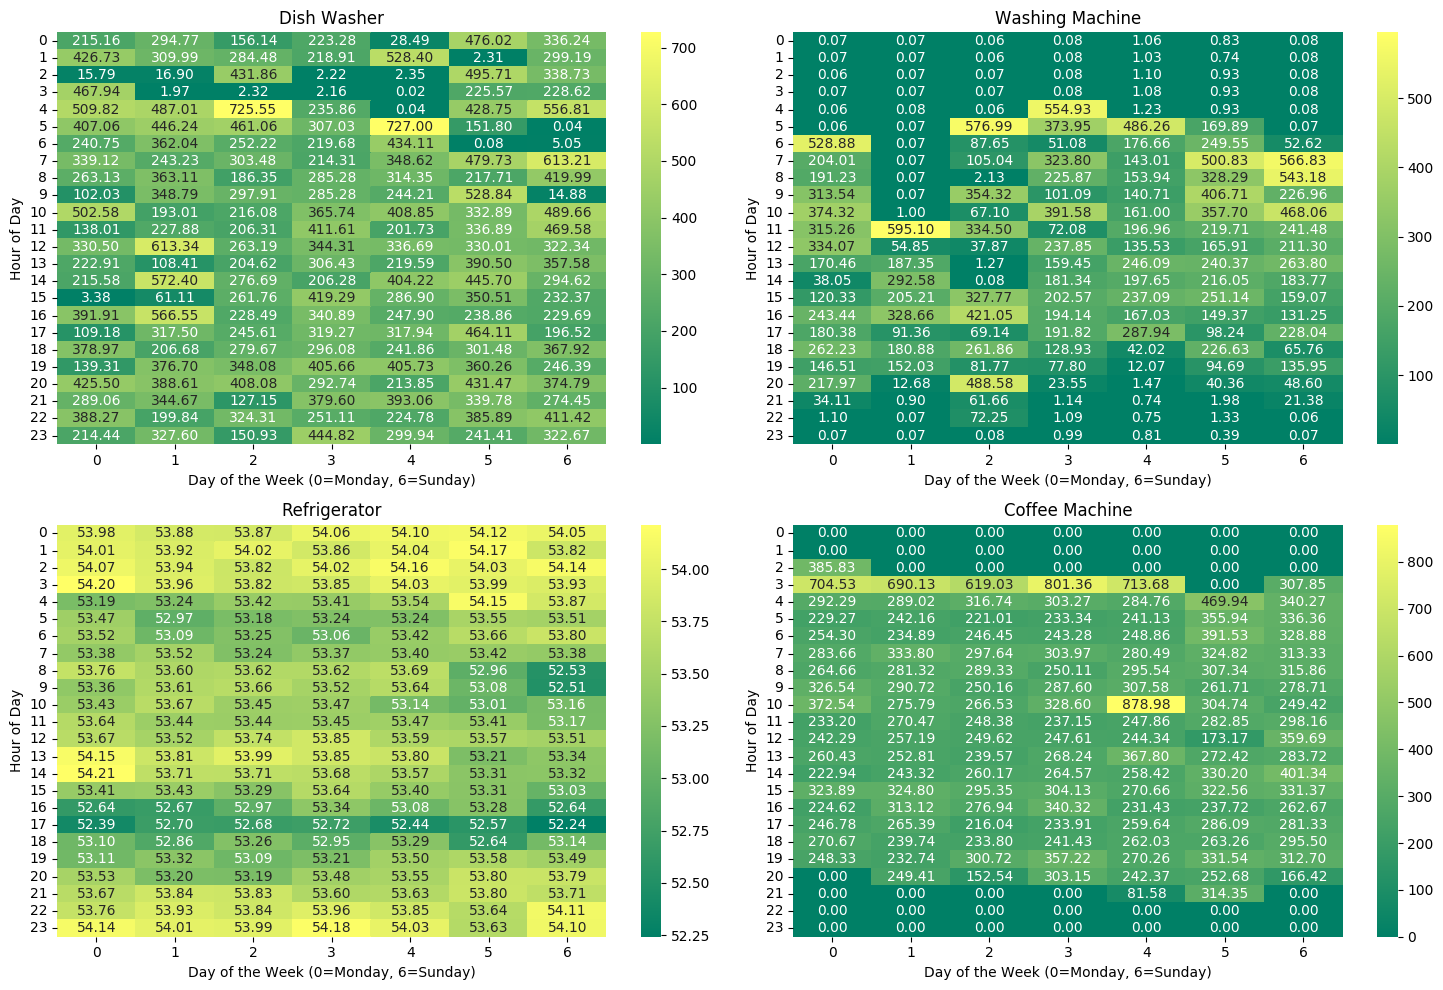

In [66]:
# Number of appliances
num_appliances = len(dataframes_dict)

# Set up the subplot grid
nrows = int(num_appliances ** 0.5)
ncols = (num_appliances // nrows) + (num_appliances % nrows > 0)

plt.figure(figsize=(15, nrows * 5))  # Adjust figure size as needed

for i, (item_id, df) in enumerate(dataframes_dict.items(), start=1):
    appliance_name = map_item_id_to_name(appliances_df, [item_id])[0]  # Get appliance name
    # Extract hour and day of the week from the index
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    # Pivot the DataFrame to get hourly values for each day of the week
    pivot_df = df.pivot_table(values='value', index='hour', columns='day_of_week', aggfunc='mean')
    

    # Plot the heatmap in a subplot
    ax = plt.subplot(nrows, ncols, i)
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='summer', ax=ax)
    ax.set_title(appliance_name)
    ax.set_xlabel('Day of the Week (0=Monday, 6=Sunday)')
    ax.set_ylabel('Hour of Day')

plt.tight_layout()
plt.show()

